<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

[breast-histopathology-images](https://www.kaggle.com/paultimothymooney/breast-histopathology-images)

https://www.kaggle.com/debajyoti1/cnn-breast-idc

In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from glob import glob
import random
from tensorflow import keras
import matplotlib.pyplot as plt

In [23]:
mypaths=[]
for name in glob('Inputs/IDC_regular_ps50_idx5/*',recursive=True):
    mypaths.append(name)
print(mypaths[:5])


['Inputs/IDC_regular_ps50_idx5/9036', 'Inputs/IDC_regular_ps50_idx5/10268', 'Inputs/IDC_regular_ps50_idx5/10257', 'Inputs/IDC_regular_ps50_idx5/8913', 'Inputs/IDC_regular_ps50_idx5/13613']


In [24]:
mp=mypaths[60:75]
imagePatches=[]
for i in mp:
    imagePatches+=glob(i+'/*/*.png', recursive=True)


In [25]:
print('total no. of images selected from total images is '+str(len(imagePatches)))


total no. of images selected from total images is 13176


In [26]:
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)


In [27]:
print('Among them, '+str(len(class0))+' is clss0 and '+str(len(class1))+' is class1')


Among them, 10096 is clss0 and 3080 is class1


In [28]:
sampled_class0 = random.sample(class0, len(class1))
sampled_class1 = random.sample(class1, len(class1))
print(len(sampled_class0), len(sampled_class1))


3080 3080


In [29]:
from matplotlib.image import imread
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import skimage.io

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = skimage.io.imread(i)
            img_sized = resize(img, (224, 224))
            img_arrays.append([img_sized, label])
    return img_arrays


In [30]:
%%time 
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

CPU times: user 44.7 s, sys: 1.22 s, total: 45.9 s
Wall time: 16.2 s


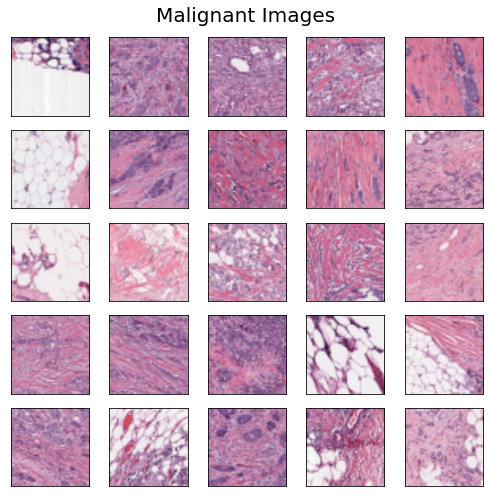

In [31]:

plt.figure(figsize=(7,7))
plt.suptitle("Malignant Images", fontsize=20)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(class1_array[i][0])
#    plt.imshow(train_images[i], cmap=plt.cm.binary)
#    plt.xlabel(class_names[train_labels[i]])

plt.tight_layout()
plt.savefig('Cancer-Images.png')  


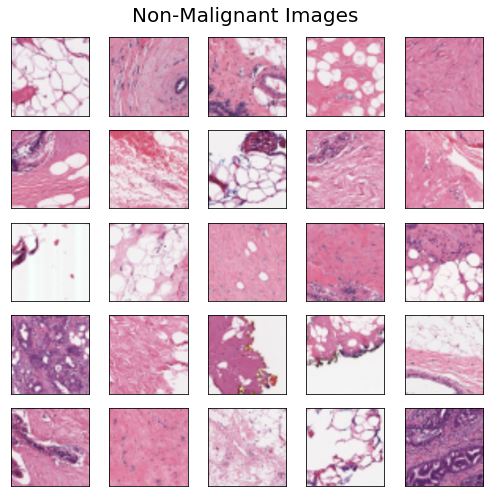

In [32]:
plt.figure(figsize=(7,7))
plt.suptitle("Non-Malignant Images", fontsize=20)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(class0_array[i][0])
#    plt.imshow(train_images[i], cmap=plt.cm.binary)
#    plt.xlabel(class_names[train_labels[i]])
plt.tight_layout()
plt.savefig('non-Cancer-Images.png')  
plt.show()


In [33]:
combined_data = np.concatenate((class0_array, class1_array))

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [34]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [35]:
X = np.array(X).reshape(-1, 224, 224, 3)


In [36]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(4620, 224, 224, 3) (1540, 224, 224, 3) (4620, 2) (1540, 2)


In [41]:
X_train

array([[[[0.89778763, 0.61295604, 0.72899699],
         [0.90055827, 0.62516014, 0.73711352],
         [0.90188818, 0.63101811, 0.74100945],
         ...,
         [0.8865615 , 0.6189833 , 0.73126547],
         [0.88828719, 0.62338943, 0.73504324],
         [0.89188238, 0.63256889, 0.74291357]],

        [[0.89618152, 0.60852849, 0.72485862],
         [0.89836599, 0.61975564, 0.73082585],
         [0.89941453, 0.62514467, 0.73369012],
         ...,
         [0.88878114, 0.63511866, 0.7417306 ],
         [0.88975653, 0.63699253, 0.74382018],
         [0.89178859, 0.64089644, 0.74817349]],

        [[0.89541059, 0.60640326, 0.7228722 ],
         [0.89731369, 0.61716147, 0.72780776],
         [0.89822718, 0.62232541, 0.73017684],
         ...,
         [0.88984656, 0.64286363, 0.74675386],
         [0.89046181, 0.64352202, 0.74803312],
         [0.89174357, 0.64489366, 0.75069825]],

        ...,

        [[0.95150646, 0.94366332, 0.94901961],
         [0.95233101, 0.94448787, 0.94901961]

In [37]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout,Dense,Flatten, BatchNormalization

def createModel():
    model = models.Sequential()
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), 
                     padding='same', activation='relu', 
                     input_shape=(224, 224, 3)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2,2), padding='valid'))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2,2), padding='valid'))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))    
    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2,2), padding='valid'))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))    
    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2,2), padding='valid'))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))    

    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2,2), padding='valid'))

    # FC Layers 
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    
    return model

model = createModel()

In [38]:
from keras_sequential_ascii import keras2ascii
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    224  224    3
              Conv2D    \|/  -------------------      1792     0.0%
                relu   #####    224  224   64
              Conv2D    \|/  -------------------     36928     0.0%
                relu   #####    224  224   64
  BatchNormalization    μ|σ  -------------------       256     0.0%
                       #####    224  224   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####    112  112   64
              Conv2D    \|/  -------------------     73856     0.1%
                relu   #####    112  112  128
              Conv2D    \|/  -------------------    147584     0.1%
                relu   #####    110  110  128
  BatchNormalization    μ|σ  -------------------       512     0.0%
                       #####    110  110  128
        MaxPooling2D   Y max -------------------         0     0.0%
              

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 110, 110, 128)     147584    
_________________________________________________________________
batch_normalization_6 (Batch (None, 110, 110, 128)    

In [40]:
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [43]:
X_train.shape

(4620, 224, 224, 3)

In [44]:
%%time 

history=model.fit(X_train,y_train, validation_data=(X_test, y_test),
                  epochs=10)


2021-09-16 12:51:54.533307: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-16 12:51:54.536197: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2021-09-16 12:51:55.642728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


145/145 [==============================] - ETA: 0s - loss: 1.3072 - accuracy: 0.6530

2021-09-16 13:00:33.115891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


145/145 [==============================] - 561s 4s/step - loss: 1.3072 - accuracy: 0.6530 - val_loss: 0.6975 - val_accuracy: 0.5104
Epoch 2/10
145/145 [==============================] - 605s 4s/step - loss: 0.7850 - accuracy: 0.7816 - val_loss: 0.7949 - val_accuracy: 0.5104
Epoch 3/10
145/145 [==============================] - 606s 4s/step - loss: 0.6729 - accuracy: 0.7976 - val_loss: 0.9542 - val_accuracy: 0.5104
Epoch 4/10
145/145 [==============================] - 623s 4s/step - loss: 0.5979 - accuracy: 0.8139 - val_loss: 0.5013 - val_accuracy: 0.7909
Epoch 5/10
145/145 [==============================] - 636s 4s/step - loss: 0.5403 - accuracy: 0.8271 - val_loss: 0.3466 - val_accuracy: 0.8584
Epoch 6/10
145/145 [==============================] - 647s 4s/step - loss: 0.5080 - accuracy: 0.8260 - val_loss: 0.3345 - val_accuracy: 0.8675
Epoch 7/10
145/145 [==============================] - 710s 5s/step - loss: 0.4774 - accuracy: 0.8396 - val_loss: 0.3204 - val_accuracy: 0.8721
Epoch 8/10

In [45]:
e=model.evaluate(X_test,y_test)

49/49 [==============================] - 54s 1s/step - loss: 0.3031 - accuracy: 0.8760


In [46]:
print(e)


[0.3030856251716614, 0.8759739995002747]


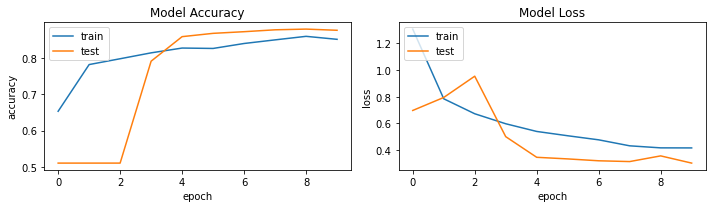

In [58]:
#plotting the Accuracy of test and training sets

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.tight_layout()
plt.savefig('loss_acc_vgg19.png')

plt.show()

In [48]:
y_pred=model.predict(X_test)


2021-09-16 14:39:57.818248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [49]:
y_pred[21]


array([0.9941199, 0.0058802], dtype=float32)

In [50]:
Y_pred=[]
for i in y_pred:
    if i[0]>i[1]:
        Y_pred.append(0)
    else:
        Y_pred.append(1)

In [51]:
Y_test=[]
for i in y_test:
    if i[0]>i[1]:
        Y_test.append(0)
    else:
        Y_test.append(1)


In [52]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(Y_test, Y_pred))
print('Classification Report')
print(classification_report(Y_test, Y_pred, target_names=['Negative','Positive']))


Confusion Matrix
[[705  81]
 [110 644]]
Classification Report
              precision    recall  f1-score   support

    Negative       0.87      0.90      0.88       786
    Positive       0.89      0.85      0.87       754

    accuracy                           0.88      1540
   macro avg       0.88      0.88      0.88      1540
weighted avg       0.88      0.88      0.88      1540



In [53]:
model.save('modelcnn.h5')


In [54]:
confusionmatrix=confusion_matrix(Y_test, Y_pred)
confusionmatrix.shape


(2, 2)

In [55]:
classes=[0,1]
con_mat_df = pd.DataFrame(confusion_matrix(Y_test, Y_pred),
                     index = classes, 
                     columns = classes)


In [56]:
import seaborn as sns

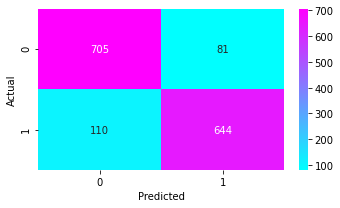

In [59]:
figure = plt.figure(figsize=(5, 3))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.savefig('CM_by_vgg19.png')

plt.show()
